In [2]:
library(h2o)


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: 'h2o'

The following objects are masked from 'package:stats':

    cor, sd, var

The following objects are masked from 'package:base':

    %*%, %in%, &&, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc



In [3]:
h2o.init()

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 hours 1 minutes 
    H2O cluster version:        3.10.3.5 
    H2O cluster version age:    13 days  
    H2O cluster name:           H2O_started_from_R_Yamini_ech830 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.59 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    R Version:                  R version 3.3.2 (2016-10-31) 



In [4]:
prosPath = system.file("extdata", "prostate.csv", package = "h2o")
prostate_df <- read.csv(prosPath)

In [5]:
set.seed(1234)
random_splits <- runif(nrow(prostate_df))
train_df <- prostate_df[random_splits < .5,]
dim(train_df)

[1] 193   9

In [8]:
head(train_df)

,ID,CAPSULE,AGE,RACE,DPROS,DCAPS,PSA,VOL,GLEASON
1,1,0,65,1,2,1,1.4,0.0,6
7,7,0,68,2,4,2,31.9,0.0,7
8,8,0,61,2,4,2,66.7,27.2,7
13,13,1,72,1,4,2,22.7,0.0,9
15,15,0,75,1,1,1,7.5,0.0,5
17,17,0,75,2,1,1,2.5,0.0,5


In [9]:
validate_df <- prostate_df[random_splits >=.5,]
dim(validate_df)

[1] 187   9

In [10]:
outcome_name <- 'CAPSULE'
feature_names <- setdiff(names(prostate_df), outcome_name)

In [13]:
feature_names

[1] "ID"      "AGE"     "RACE"    "DPROS"   "DCAPS"   "PSA"     "VOL"    
[8] "GLEASON"

In [14]:
prostate.hex<-as.h2o(train_df, destination_frame="train.hex")

  |======================================================================| 100%


In [15]:
head(prostate.hex)

ID,CAPSULE,AGE,RACE,DPROS,DCAPS,PSA,VOL,GLEASON
1,0,65,1,2,1,1.4,0.0,6
7,0,68,2,4,2,31.9,0.0,7
8,0,61,2,4,2,66.7,27.2,7
13,1,72,1,4,2,22.7,0.0,9
15,0,75,1,1,1,7.5,0.0,5
17,0,75,2,1,1,2.5,0.0,5


In [16]:
prostate.dl = h2o.deeplearning(x = feature_names, training_frame = prostate.hex,
                               autoencoder = TRUE,
                               reproducible = T,
                               seed = 1234,
                               hidden = c(6,5,6), epochs = 50)

  |======================================================================| 100%


In [18]:
prostate.dl

Model Details:

H2OAutoEncoderModel: deeplearning
Model ID:  DeepLearning_model_R_1488573890941_1 
Status of Neuron Layers: auto-encoder, gaussian distribution, Quadratic loss, 181 weights/biases, 6.9 KB, 2,316 training samples, mini-batch size 1
  layer units      type dropout       l1       l2 mean_rate rate_rms momentum
1     1     8     Input  0.00 %                                              
2     2     6 Rectifier  0.00 % 0.000000 0.000000  0.007952 0.003614 0.000000
3     3     5 Rectifier  0.00 % 0.000000 0.000000  0.003152 0.001663 0.000000
4     4     6 Rectifier  0.00 % 0.000000 0.000000  0.002366 0.001949 0.000000
5     5     8 Rectifier         0.000000 0.000000  0.003682 0.005102 0.000000
  mean_weight weight_rms mean_bias bias_rms
1                                          
2    0.033625   0.419705  0.526721 0.253438
3   -0.112884   0.399731  0.983416 0.098159
4   -0.007209   0.457098  1.001498 0.116803
5   -0.123573   0.380468 -0.052076 0.049782


H2OAutoEncoderMetri

In [19]:
prostate.anon = h2o.anomaly(prostate.dl, prostate.hex, per_feature=FALSE)
head(prostate.anon)

Reconstruction.MSE
0.03988444
0.14211926
0.17585169
0.10316385
0.07844050
0.10470483


In [20]:
err <- as.data.frame(prostate.anon)

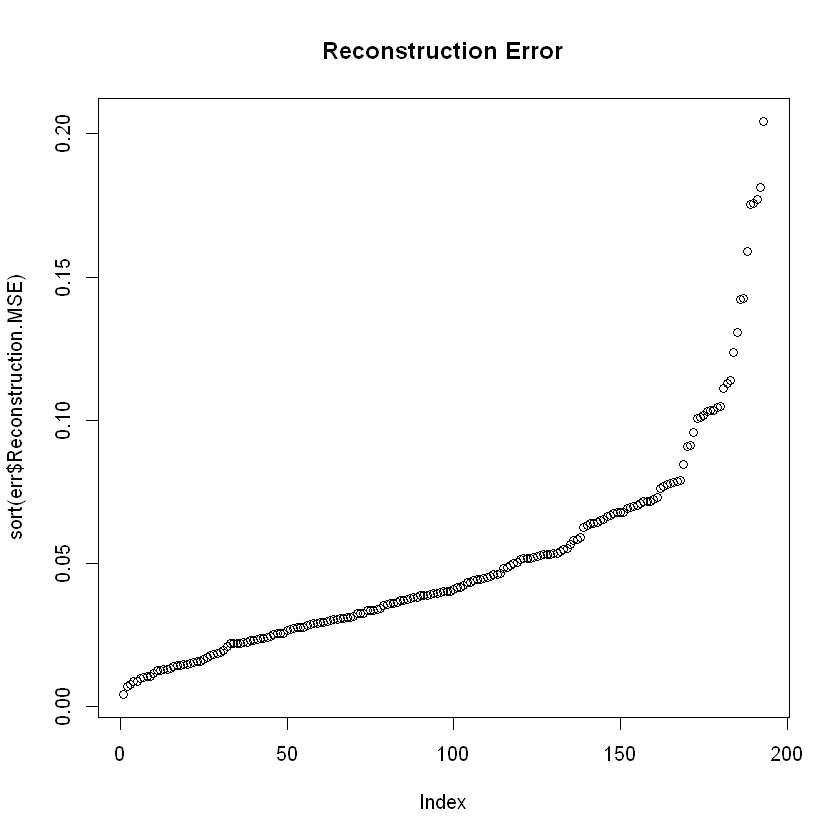

In [21]:
plot(sort(err$Reconstruction.MSE), main='Reconstruction Error')